# Influencers in Social Networks: Predict which people are influential in a social network

W207.1 Final Project Submission for Byun, Chio, Danish, Hamlin, Pazo, Fall 2015

# Problem Statement

Kaggle Competition: https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data 

"Influencers in Social Networks: Predict which people are influential in a social network"

The dataset, provided by Peerindex, comprises a standard, pair-wise preference learning task. Each datapoint describes two individuals, A and B. For each person, 11 pre-computed, non-negative numeric features based on twitter activity (such as volume of interactions, number of followers, etc) are provided.

The binary label represents a human judgement about which one of the two individuals is more influential. A label '1' means A is more influential than B. 0 means B is more influential than A. 

The goal of the challenge is to train a machine learning model which, for pairs of individuals, predicts the human judgement on who is more influential with high accuracy.

# Data Import

In [15]:
# Import all the necessary libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hashlib

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import networkx as nx

In [6]:
# Load the train and test data
def load_train_data():
    with open('data/train.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        data = np.loadtxt(f, delimiter=',')
        X, Y = data[:,1:], data[:,:1]
        return features, X, Y.flatten()

def load_test_data():
    with open('data/test.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        return np.loadtxt(f, delimiter=',')

def prepare_train_data(X, Y, test_size=1.0/6):
    np.random.seed(0)
    
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    break_point = int(X.shape[0] * (1 - test_size))
    return X[:break_point], Y[:break_point], X[break_point:], Y[break_point:]
    
features, X, Y = load_train_data()
train_data, train_labels, dev_data, dev_labels = prepare_train_data(X, Y)
test_data = load_test_data()

print train_data.shape, dev_data.shape, test_data.shape

(4583, 22) (917, 22) (5952, 22)


# Utility Functions

In [7]:
def log_features(x):
    return np.log(1+x)

def standardize_features(x):
    return StandardScaler().fit_transform(x)

def pairwise_diff(data):
    return data[:,0:11] - data[:,11:]

def pairwise_transform(data):
    return log_features(data[:,0:11]) - log_features(data[:,11:])

def pairwise_features_transform(features):
    return ['d_'+feature[2:] for feature in features[:11]]

train_data_transformed = pairwise_transform(train_data)
dev_data_transformed = pairwise_transform(dev_data)
features_transformed = pairwise_features_transform(features)
X_transformed = pairwise_transform(X)
test_data_transformed = pairwise_transform(test_data)

In [8]:
def train_gridsearch_classifier(classifier, param, train_data, train_labels):
    """Use GridSearchCV to find the best estimator using the specified parameters.
    
    f1_weighted is used as the scoring metric.
    
    @param classfier: The base classifier.
    @param param: The parameters to be evaluated.
    @param train_data: The training data.
    @param train_labels: The training labels.
    @return The Grid classifier trained with the best estimator.
    """
    grid_cls = GridSearchCV(classifier, param, scoring='accuracy')
    grid_cls.fit(train_data, train_labels)
    return grid_cls

def report_score(grid_cls, dev_data, dev_labels):
    """Report the result from  GridSearchCV.
    
    Example:
    ---------------------------------------------------------------
    Parameters scores:
    mean: 0.40479, std: 0.01913, params: {'n_neighbors': 1}
    mean: 0.40851, std: 0.02859, params: {'n_neighbors': 5}
    mean: 0.41284, std: 0.02365, params: {'n_neighbors': 10}
    mean: 0.42409, std: 0.01053, params: {'n_neighbors': 50}

    Best param: {'n_neighbors': 50}, f1-score: 0.418
    ---------------------------------------------------------------
    
    @param grid_cls: A trained classifier using GridSearchCV.
    @param dev_data: The development data.
    @param dev_labels: The development labels.
    """
    pred_labels = grid_cls.predict(dev_data)
    print "Parameters scores:"
    for grid_score in grid_cls.grid_scores_:
        print grid_score
    print "\n"
    print "Best param: %(best)s, accuracy: %(score)s" % {
        'best': grid_cls.best_params_, 'score': round(metrics.accuracy_score(dev_labels, pred_labels), 3)
    }

In [ ]:
# Usage
# print "Logistic Regression:\n"
# params = {'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
# lg_grid_cls = train_gridsearch_classifier(LogisticRegression(),
#                                        params,
#                                        train_data_transformed, train_labels)
# report_score(lg_grid_cls, dev_data_transformed, dev_labels)

In [9]:
def plot_two_dim_data(data, labels, first_dim=0, second_dim=1):
    plt.scatter(data[:, first_dim], data[:, second_dim],
          c=labels, cmap=ListedColormap(['red', 'blue']), alpha=0.5)

def plot_combinatory_two_dim_data(data, labels):
    plt.figure(figsize=(20, 20))
    features_len = data.shape[1]
    for i in range(0, features_len):
        c = 1
        for j in range(i+1, features_len):
            plt.subplot(features_len, features_len, (i+1)*features_len + c)
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            plot_two_dim_data(data, labels, i, j)
            c += 1

In [10]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

# Data Exploration

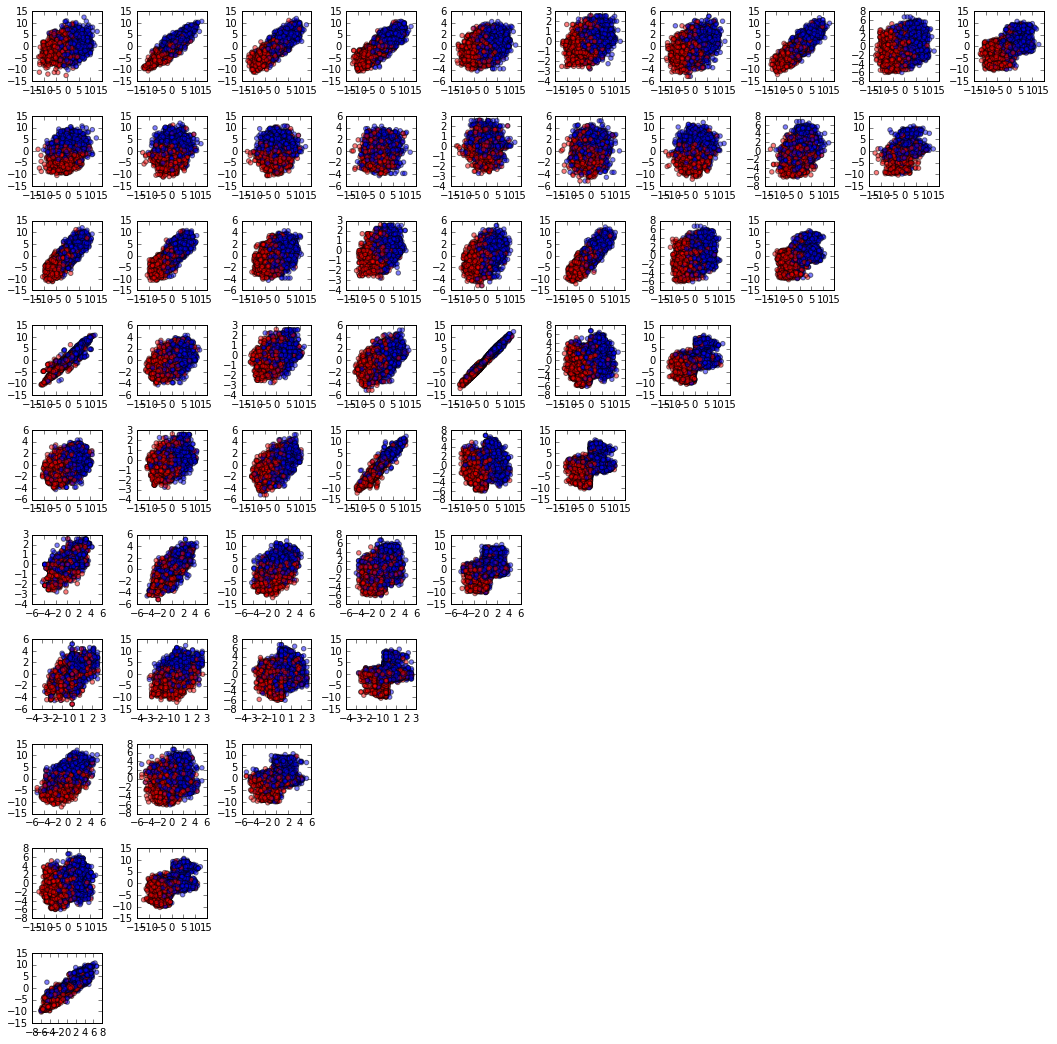

In [8]:
plot_combinatory_two_dim_data(train_data_transformed, train_labels)

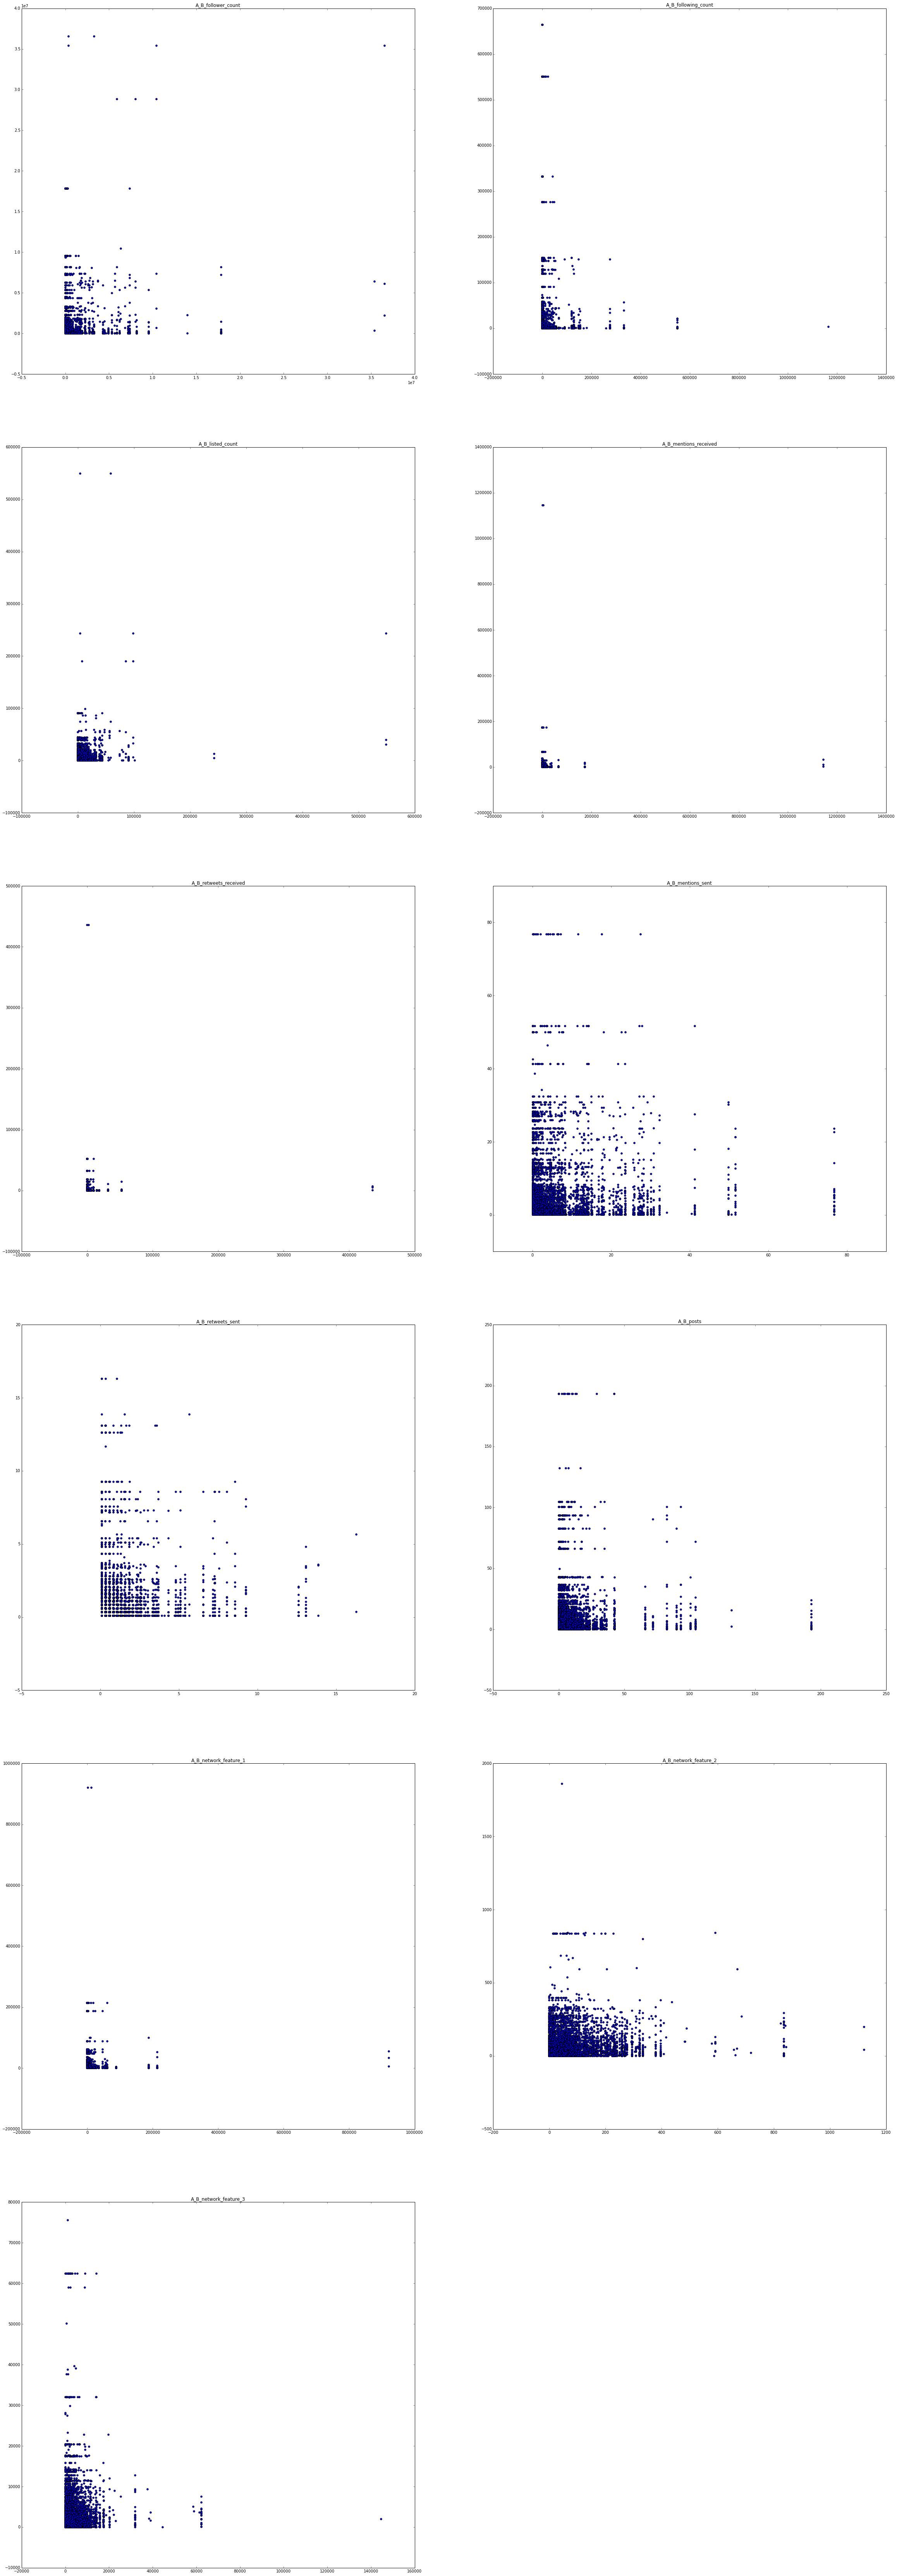

In [4]:
# creating plots of our raw data for the training data 
fig = plt.figure(figsize=(40,220))

ax1=fig.add_subplot(11,2,1)
ax2=fig.add_subplot(11,2,2)
ax3=fig.add_subplot(11,2,3)
ax4=fig.add_subplot(11,2,4)
ax5=fig.add_subplot(11,2,5)
ax6=fig.add_subplot(11,2,6)
ax7=fig.add_subplot(11,2,7)
ax8=fig.add_subplot(11,2,8)
ax9=fig.add_subplot(11,2,9)
ax10=fig.add_subplot(11,2,10)
ax11=fig.add_subplot(11,2,11)

ax1.scatter(X[:,0],X[:,11])
ax1.set_title('A_B_follower_count') # keep

ax2.scatter(X[:,1],X[:,12])
ax2.set_title('A_B_following_count') # keep

ax3.scatter(X[:,2],X[:,13])
ax3.set_title('A_B_listed_count')

ax4.scatter(X[:,3],X[:,14])
ax4.set_title('A_B_mentions_received') # keep

ax5.scatter(X[:,4],X[:,15])
ax5.set_title('A_B_retweets_received')

ax6.scatter(X[:,5],X[:,16])
ax6.set_title('A_B_mentions_sent') # keep

ax7.scatter(X[:,6],X[:,17])
ax7.set_title('A_B_retweets_sent') # keep

ax8.scatter(X[:,7],X[:,18])
ax8.set_title('A_B_posts')

ax9.scatter(X[:,8],X[:,19])
ax9.set_title('A_B_network_feature_1')

ax10.scatter(X[:,9],X[:,20])
ax10.set_title('A_B_network_feature_2')  # keep

ax11.scatter(X[:,10],X[:,21])
ax11.set_title('A_B_network_feature_3') # keep

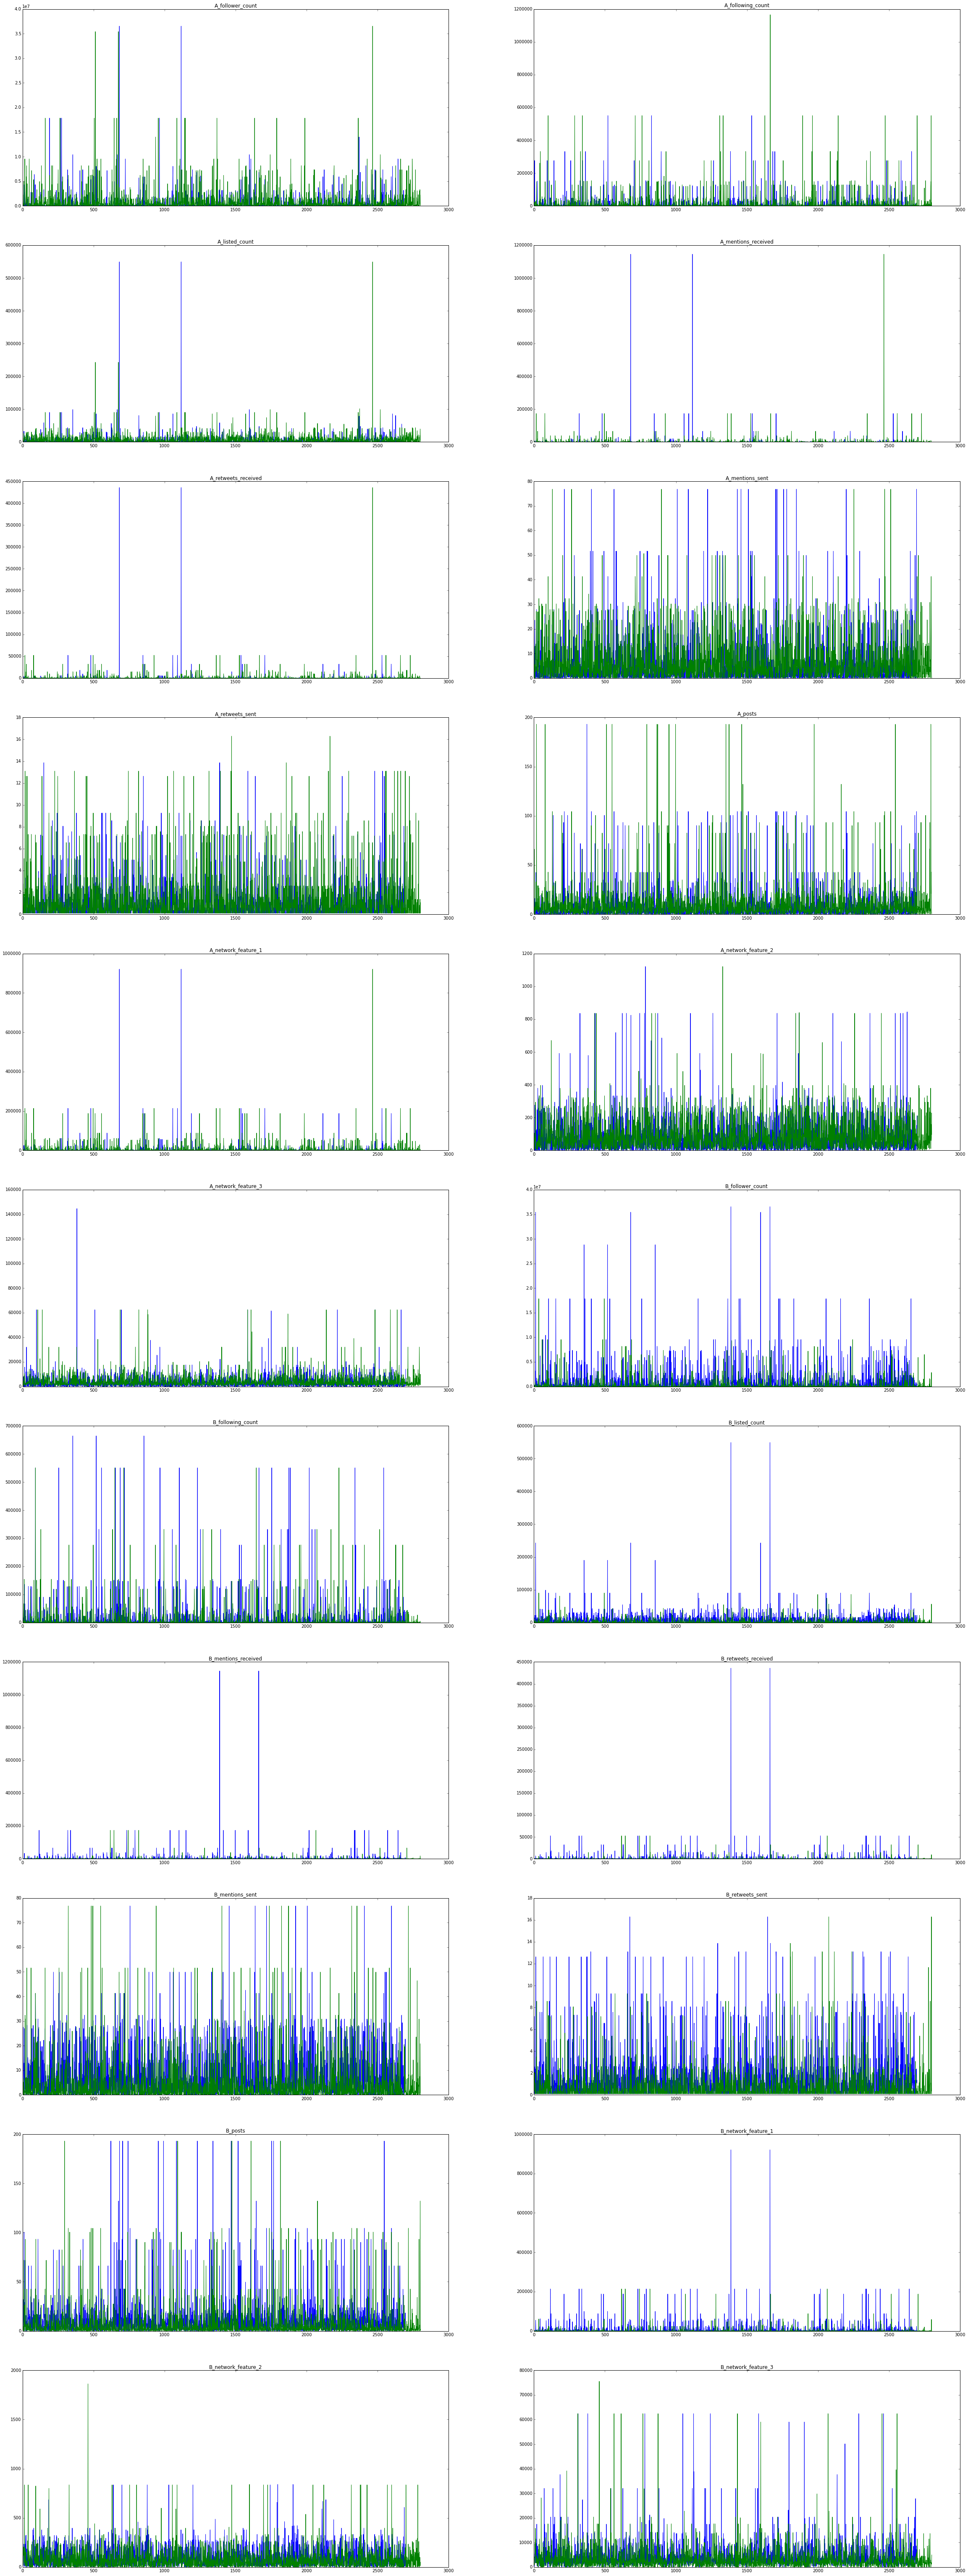

In [5]:
# creating plots of our raw data for the training data with label = 0
train_data_0 = X[Y==0]
train_data_1 = X[Y==1]

fig = plt.figure(figsize=(40,220))

ax1=fig.add_subplot(22,2,1)
ax2=fig.add_subplot(22,2,2)
ax3=fig.add_subplot(22,2,3)
ax4=fig.add_subplot(22,2,4)
ax5=fig.add_subplot(22,2,5)
ax6=fig.add_subplot(22,2,6)
ax7=fig.add_subplot(22,2,7)
ax8=fig.add_subplot(22,2,8)
ax9=fig.add_subplot(22,2,9)
ax10=fig.add_subplot(22,2,10)
ax11=fig.add_subplot(22,2,11)
ax12=fig.add_subplot(22,2,12)
ax13=fig.add_subplot(22,2,13)
ax14=fig.add_subplot(22,2,14)
ax15=fig.add_subplot(22,2,15)
ax16=fig.add_subplot(22,2,16)
ax17=fig.add_subplot(22,2,17)
ax18=fig.add_subplot(22,2,18)
ax19=fig.add_subplot(22,2,19)
ax20=fig.add_subplot(22,2,20)
ax21=fig.add_subplot(22,2,21)
ax22=fig.add_subplot(22,2,22)

ax1.plot(train_data_0[:,0])
ax1.plot(train_data_1[:,0])
ax1.set_title('A_follower_count')

ax2.plot(train_data_0[:,1])
ax2.plot(train_data_1[:,1])
ax2.set_title('A_following_count')

ax3.plot(train_data_0[:,2])
ax3.plot(train_data_1[:,2])
ax3.set_title('A_listed_count')

ax4.plot(train_data_0[:,3])
ax4.plot(train_data_1[:,3])
ax4.set_title('A_mentions_received')

ax5.plot(train_data_0[:,4])
ax5.plot(train_data_1[:,4])
ax5.set_title('A_retweets_received')

ax6.plot(train_data_0[:,5])
ax6.plot(train_data_1[:,5])
ax6.set_title('A_mentions_sent')

ax7.plot(train_data_0[:,6])
ax7.plot(train_data_1[:,6])
ax7.set_title('A_retweets_sent')

ax8.plot(train_data_0[:,7])
ax8.plot(train_data_1[:,7])
ax8.set_title('A_posts')

ax9.plot(train_data_0[:,8])
ax9.plot(train_data_1[:,8])
ax9.set_title('A_network_feature_1')

ax10.plot(train_data_0[:,9])
ax10.plot(train_data_1[:,9])
ax10.set_title('A_network_feature_2')

ax11.plot(train_data_0[:,10])
ax11.plot(train_data_1[:,10])
ax11.set_title('A_network_feature_3')

ax12.plot(train_data_0[:,11])
ax12.plot(train_data_1[:,11])
ax12.set_title('B_follower_count')

ax13.plot(train_data_0[:,12])
ax13.plot(train_data_1[:,12])
ax13.set_title('B_following_count')

ax14.plot(train_data_0[:,13])
ax14.plot(train_data_1[:,13])
ax14.set_title('B_listed_count')

ax15.plot(train_data_0[:,14])
ax15.plot(train_data_1[:,14])
ax15.set_title('B_mentions_received')

ax16.plot(train_data_0[:,15])
ax16.plot(train_data_1[:,15])
ax16.set_title('B_retweets_received')

ax17.plot(train_data_0[:,16])
ax17.plot(train_data_1[:,16])
ax17.set_title('B_mentions_sent')

ax18.plot(train_data_0[:,17])
ax18.plot(train_data_1[:,17])
ax18.set_title('B_retweets_sent')

ax19.plot(train_data_0[:,18])
ax19.plot(train_data_1[:,18])
ax19.set_title('B_posts')

ax20.plot(train_data_0[:,19])
ax20.plot(train_data_1[:,19])
ax20.set_title('B_network_feature_1')

ax21.plot(train_data_0[:,20])
ax21.plot(train_data_1[:,20])
ax21.set_title('B_network_feature_2')

ax22.plot(train_data_0[:,21])
ax22.plot(train_data_1[:,21])
ax22.set_title('B_network_feature_3')

# Feature Engineering

In [6]:
# new X using new features

#new_features = [0, 1, 3, 5, 6, 9, 10, 11, 12, 14, 16, 17, 20, 21]
new_features = range(22)
def remove_features(features_to_keep, X):    
    new_X = np.zeros((len(X[:,0]),len(new_features)))

    for i in range(0,len(new_features)):
        new_X[:,i] = X[:,new_features[i]]

    return new_X

X = remove_features(new_features, X)
test_data = remove_features(new_features, test_data)

In [7]:
## Useful functions

num_feat = (len(new_features))/2

# Pairwise transform:
# Divide each row in two parts, one for each person in the comparison and subtract the logs of them.
# A +1 factor is used to have only non-negative logs.
def trans(x):
    return np.log(1 + x[:,:num_feat]) - np.log(1 + x[:,num_feat:] )

# Rolling-hash on the features of a person
def hash(a):
    base = 100
    res = 0
    for i in range(len(a)):
        res += base ** i * a[i]
    return res

# Creates an undirected graph where all the rows, which are comparisons, are represented by edges.
def get_edges(x):
    A = x[:,:num_feat]
    B = x[:,num_feat:]

    mapa = {}
    tot = 0
    edges = []
    adj = {}
    for i in range(len(A)):
        a = hash(list(A[i]))
        if a not in mapa:
            mapa[a] = tot
            adj[tot] = set()
            tot += 1
        b = hash(list(B[i]))
        if b not in mapa:
            mapa[b] = tot
            adj[tot] = set()
            tot += 1
        edges.append((mapa[a], mapa[b]))
        adj[mapa[a]].add(mapa[b])
        adj[mapa[b]].add(mapa[a])
    return edges, tot, adj

# Given the probability predictions, print the output in the format Kaggle can accept.
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(0.6 if prob[1] == 0.5 else prob[1])+'\n')
            
# Pairwise transform for simple numbers
def subtractlogs(a, b):
    return np.log(1 + a) - np.log(1 + b)

# Given two sets of features, create a graph of their combination
def create_graph(x1, x2):
    x = np.concatenate((x1, x2))
    edges, n, adj = get_edges(x)
    ug = nx.Graph()
    map(lambda i: ug.add_node(i), range(n))
    map(lambda (a, b): ug.add_edge(a, b), edges)
    return ug

# Modeling

In [8]:
# Create an undirected graph of the combination of the train and test data
ug = create_graph(trans(X), trans(test_data))

In [9]:
# Calculate several graph centrality measures
pr = nx.pagerank(ug)
degc = nx.degree_centrality(ug)
close = nx.closeness_centrality(ug)
load = nx.load_centrality(ug)
bet = nx.betweenness_centrality(ug)
ecc = nx.eccentricity(ug)

In [10]:
def network_features(x1, x2):
    x = np.concatenate((x1, x2))
    edges, n, adj = get_edges(x)
    features = []
    for i in range(len(x)):
        a = edges[i][0]
        b = edges[i][1]
        features.append([
            subtractlogs(degc[a], degc[b]),
            subtractlogs(close[a], close[b]),
            subtractlogs(len(adj[a]), len(adj[b])),
            subtractlogs(load[a], load[b]),
            subtractlogs(bet[a], bet[b]),
            subtractlogs(ecc[a], ecc[b]),
            subtractlogs(pr[a], pr[b])
        ])
    return features[:len(x1)], features[len(x1):]

x_feat, test_x_feat = network_features(trans(X), trans(test_data))

In [11]:
# Combine the original features with the network features
x = trans(X)
test_x = trans(test_data)
x_feat, test_x_feat = network_features(x, test_x)

x = np.concatenate((x, x_feat), axis=1)
test_x = np.concatenate((test_x, test_x_feat), axis=1)

In [12]:
# For every feature, make a negative copy of it, so that there's a balance between all the cases were A < B and B > A.
xx = []
yy = []
for i in range(len(Y)):
    xx.append(x[i])
    yy.append(Y[i])
    xx.append(-x[i])
    yy.append(1 - Y[i])

# For every row, append the ratio following / followers as a new feature
for i in range(len(xx)):
    xx[i] = np.append(xx[i], xx[i][0] / (xx[i][1] + 1)) 
tx = []
for i in range(len(test_x)):
    tx.append(np.append(test_x[i], test_x[i][0] / (test_x[i][0] + 1)))

In [14]:
# 0.86161
# First classifier, Bagging + LR
clf1 = BaggingClassifier(
    LogisticRegression(C=1/.60),
    max_samples=0.3, max_features=0.7, n_estimators=200, n_jobs=-1, random_state=3)
clf1.fit(xx, yy)

# Second classifier, Bagging + GBC
clf2 = BaggingClassifier(
    GradientBoostingClassifier(max_depth=2, max_features=.99, subsample=0.9),
    max_samples=0.3, max_features=0.7, n_estimators=50, n_jobs=-1, random_state=1
)
clf2.fit(xx, yy)

BaggingClassifier(base_estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=2, max_features=0.99, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=0.9, verbose=0,
              warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.7,
         max_samples=0.3, n_estimators=1, n_jobs=-1, oob_score=False,
         random_state=1, verbose=0)

## Reference feature
For each person A/B, noted that A in one observation can be B in another, we find the total reference count for the person and use it as a feature.

In [11]:
def feature_hash(features):
    """Return a hash for the feature array.
    
    @param features: The feature array.
    @return a hash.
    """
    return hashlib.sha1(features).hexdigest()

def generate_reference_dict(data):
    """Generate reference count for A and B in the data set.
    
    Reference count refer to the total occurence for a person among all
    the observations. Noted that, for each A in an observation, the same person can
    occur in B in another observation. Similarly, B in an observation can occur in A
    in another one.
    
    Return a dictionary for which the key and the feature hash and value is the
    reference count.
    
    @param data: The original non-transformed data.
    @return A dictionary containing the reference count for a person.
    """
    reference_count = {}
    for d in data:
        key_A = feature_hash(d[0:11])
        key_B = feature_hash(d[11:])
        if key_A not in reference_count:
            reference_count[key_A] = 1
        else:
            reference_count[key_A] += 1
        if key_B not in reference_count:
            reference_count[key_B] = 1
        else:
            reference_count[key_B] += 1
    return reference_count

def generate_reference_features(data, reference_dict):
    """Generate reference features for A and B in the data set based on the reference count
    dictionary.
    
    A new feature matrix with dimension (n_samples, 2) is returned with
    first dimension being the reference count for A and second being
    the reference count for B.
    
    @param data: The original non-transformed data.
    @return The new feature matrix.
    """
    reference_features = np.ones((data.shape[0], 2))
    
    for i, d in enumerate(data):
        key_A = feature_hash(d[0:11])
        key_B = feature_hash(d[11:])
        reference_features[i,0] = reference_dict[key_A]
        reference_features[i,1] = reference_dict[key_B]
    return reference_features

# combine train and test data to calculate the total reference count for a person.
reference_dict = generate_reference_dict(np.vstack((X, test_data)))

## Generate new train and test data with new reference features

In [12]:
# For train data set
X_reference_features = generate_reference_features(X, reference_dict)
ref_feature_transformed = X_reference_features[:,0] - X_reference_features[:,1]
# run through the same prepare_train_data process to split data into train and dev set
ref_train_data, unused, ref_dev_data, unused = prepare_train_data(ref_feature_transformed, ref_feature_transformed)
train_data_transformed_with_ref = np.hstack((train_data_transformed, ref_train_data[:,np.newaxis]))
dev_data_transformed_with_ref = np.hstack((dev_data_transformed, ref_dev_data[:,np.newaxis]))

# For test data set
test_ref_feature = generate_reference_features(test_data, reference_dict)
test_ref_feature_transformed = test_ref_feature[:,0] - test_ref_feature[:,1]
X_transformed_with_ref = np.hstack((X_transformed, ref_feature_transformed[:,np.newaxis]))
test_data_transformed_with_ref = np.hstack((test_data_transformed, test_ref_feature_transformed[:,np.newaxis]))

## Examine new feature

[[ 84.  79.]
 [ 95.  83.]
 [  1.   3.]
 [ 82.  82.]
 [ 72.  67.]
 [ 90.  80.]
 [ 90.  73.]
 [ 71.  66.]
 [ 75.  80.]
 [ 91.  88.]]


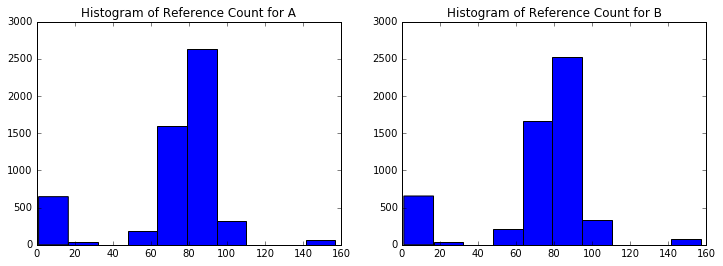

In [13]:
print X_reference_features[:10]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(X_reference_features[:,0])
plt.title("Histogram of Reference Count for A")
plt.subplot(1,2,2)
plt.hist(X_reference_features[:,1])
plt.title("Histogram of Reference Count for B")

# Modeling using reference features

In [18]:
pca_lr = Pipeline([('pca', PCA()), ('lr', LogisticRegression())])
print "Calibrate a PCA + Logistic Regression Model:\n"
params = {'pca__n_components': [8, 9, 10, 11],
          'lr__C': [0.001, 0.01, 0.1, 0.5, 1.0]}
lg_grid_cls = train_gridsearch_classifier(pca_lr,
                                       params,
                                       train_data_transformed_with_ref, train_labels)
report_score(lg_grid_cls, dev_data_transformed_with_ref, dev_labels)
print "------------------------------------------\n"

Calibrate a PCA + Logistic Regression Model:

Parameters scores:
mean: 0.76784, std: 0.00907, params: {'pca__n_components': 8, 'lr__C': 0.001}
mean: 0.76827, std: 0.00929, params: {'pca__n_components': 9, 'lr__C': 0.001}
mean: 0.76893, std: 0.01021, params: {'pca__n_components': 10, 'lr__C': 0.001}
mean: 0.76849, std: 0.01034, params: {'pca__n_components': 11, 'lr__C': 0.001}
mean: 0.76784, std: 0.00877, params: {'pca__n_components': 8, 'lr__C': 0.01}
mean: 0.77067, std: 0.00633, params: {'pca__n_components': 9, 'lr__C': 0.01}
mean: 0.77002, std: 0.00774, params: {'pca__n_components': 10, 'lr__C': 0.01}
mean: 0.76827, std: 0.00794, params: {'pca__n_components': 11, 'lr__C': 0.01}
mean: 0.76980, std: 0.00774, params: {'pca__n_components': 8, 'lr__C': 0.1}
mean: 0.76937, std: 0.00585, params: {'pca__n_components': 9, 'lr__C': 0.1}
mean: 0.76806, std: 0.00671, params: {'pca__n_components': 10, 'lr__C': 0.1}
mean: 0.76915, std: 0.00753, params: {'pca__n_components': 11, 'lr__C': 0.1}
mean:

In [31]:
print "Calibrate a Random Forest Model:\n"
params = {'n_estimators': [1, 10, 20, 50, 100, 200, 500]}
rf_grid_cls = train_gridsearch_classifier(RandomForestClassifier(),
                                       params,
                                       train_data_transformed_with_ref, train_labels)
report_score(rf_grid_cls, dev_data_transformed_with_ref, dev_labels)
print "------------------------------------------\n"

Calibrate a Random Forest Model:

Parameters scores:
mean: 0.69714, std: 0.00349, params: {'n_estimators': 1}
mean: 0.74864, std: 0.00047, params: {'n_estimators': 10}
mean: 0.75365, std: 0.00311, params: {'n_estimators': 20}
mean: 0.76347, std: 0.00630, params: {'n_estimators': 50}
mean: 0.76544, std: 0.00261, params: {'n_estimators': 100}
mean: 0.76784, std: 0.00832, params: {'n_estimators': 200}
mean: 0.76653, std: 0.00879, params: {'n_estimators': 500}


Best param: {'n_estimators': 200}, accuracy: 0.755
------------------------------------------



Using cross validation, Random Forest with 100 to 300 estimators gives the best performance. Due to the random nature of the algorithm, the best number of estimators can be any number between the range. Empirically, 200 tends to give best performance on the test data set.

## Model ensemble

In [24]:
print "Calibration for Logistic Regression + Random Forest Ensemble Model:\n"
pca_lr = Pipeline([('pca', PCA(n_components=9)), ('lr', LogisticRegression(C=0.01))])
rf = RandomForestClassifier(n_estimators=200)
lr_rf = VotingClassifier(estimators=[('pca_lr', pca_lr), ('rf', rf)], voting='soft')
params = {'weights': [[0.1, 0.9], [0.3, 0.7], [0.5, 0.5], [0.7, 0.3], [0.9, 0.1]]}

voting_grid_cls = train_gridsearch_classifier(lr_rf,
                                       params,
                                       train_data_transformed_with_ref, train_labels)
report_score(voting_grid_cls, dev_data_transformed_with_ref, dev_labels)
print "------------------------------------------\n"

Calibration for Logistic Regression + Random Forest Ensemble Model:

Parameters scores:
mean: 0.77067, std: 0.00927, params: {'weights': [0.1, 0.9]}
mean: 0.77242, std: 0.00951, params: {'weights': [0.3, 0.7]}
mean: 0.77286, std: 0.00571, params: {'weights': [0.5, 0.5]}
mean: 0.76740, std: 0.00639, params: {'weights': [0.7, 0.3]}
mean: 0.76871, std: 0.00769, params: {'weights': [0.9, 0.1]}


Best param: {'weights': [0.5, 0.5]}, accuracy: 0.756
------------------------------------------



In general, using Random Forest along with Logistic Regression improves the accuracy. To avoid overfitting, LR should have larger weight for which the calibrated ensemble model has 0.7 and 0.3 for LR and RF respectively.

In [25]:
# 0.86236
pca_lr = Pipeline([('pca', PCA(n_components=9)), ('lr', LogisticRegression(C=0.01))])
rf = RandomForestClassifier(n_estimators=200)
lr_rf = VotingClassifier(estimators=[('pca_lr', pca_lr), ('rf', rf)], voting='soft', weights=[0.7, 0.3])
lr_rf.fit(X_transformed_with_ref, Y)
pred_probs = lr_rf.predict_proba(test_data_transformed_with_ref)

generate_test_output(pred_probs)

# Neural Network

In [ ]:
class NeuralNetworkClassifier(BaseEstimator):
    def __init__(self, batch_size=20, hidden_nodes=5):
        self.predict_nn = None
        self.batch_size = batch_size
        self.hidden_nodes = hidden_nodes

    def fit(self, X, y):
        X_model = T.matrix()
        Y_model = T.vector()
        ## (1) Parameters
        params = self._param(X)

        ## (2) Model
        y_hat = self._model(X_model, params)

        ## (3) Cost...same as logistic regression
        cost = self._cost(y_hat, Y_model)

        ## (4) Minimization.  Update rule changes to backpropagation.
        update = self._backprop(cost, params)
        train = theano.function(inputs=[X_model, Y_model], outputs=cost, updates=update, allow_input_downcast=True)
        y_pred = y_hat
        self.predict_nn = theano.function(inputs=[X_model], outputs=y_pred, allow_input_downcast=True)
        
        self._gradientDescentStochastic(50, self.batch_size, X, y, train)

        return self
    
    def predict(self, X):
        return (self.predict_nn(X) > 0.5).astype(int)
    
    def predict_proba(self, X):
        pred_probs = self.predict_nn(X)[:,np.newaxis]
        output_proba = np.copy(1 - pred_probs)
        return np.hstack((output_proba, pred_probs))
    
    def _param(self, X):
        w_1 = theano.shared(np.asarray((np.random.randn(*(X.shape[1], self.hidden_nodes))*.01)))
        w_2 = theano.shared(np.asarray((np.random.randn(self.hidden_nodes)*.01)))
        return [w_1, w_2]
    
    def _model(self, X_model, params):
        activation = X_model
        for param in params:
            activation = T.nnet.sigmoid(T.dot(activation, param))
        return activation
    
    def _cost(self, y_hat, Y_model):
        return T.mean(T.nnet.binary_crossentropy(y_hat, Y_model))
    
    def _backprop(self, cost, w):
        alpha = 0.01
        grads = T.grad(cost=cost, wrt=w)
        updates = []
        for w1, grad in zip(w, grads):
            updates.append([w1, w1 - grad * alpha])
        return updates
        
    def _gradientDescentStochastic(self, epochs, miniBatchSize, X, y, train):
        for i in range(epochs):       
            for start, end in zip(
                range(0, len(train_data), miniBatchSize),
                range(miniBatchSize, len(train_data), miniBatchSize)
            ):
                train(X[start:end], y[start:end])

# Error Analysis

In [19]:
pred = clf1.predict(xx) * .72 + clf1.predict(xx) * .28
wrong = pred != yy
print sum(wrong)
    
reds = [wrong[i] and yy[i] == 1.0 for i in range(len(wrong))]
blues = [wrong[i] and yy[i] == 0.0 for i in range(len(wrong))]
print sum(reds)
print sum(blues)

2556
1333
1223


# Kaggle Submission

In [16]:
# First classifier, Bagging + LR
proba1 = clf1.predict_proba(tx)

# Second classifier, Bagging + GBC
proba2 = clf2.predict_proba(tx)

# Combine both results as a weigthed average.
generate_test_output(proba1 * .72 + proba2 * .28)

# Future Work

Talk about future work here